In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:44<00:00, 23.5MB/s]
100% 2.29G/2.29G [01:44<00:00, 23.6MB/s]
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
100% 662M/663M [00:31<00:00, 22.1MB/s]
100% 663M/663M [00:31<00:00, 22.3MB/s]


In [2]:
!unzip chest-xray-pneumonia.zip &> /dev/null
!unzip tuberculosis-tb-chest-xray-dataset.zip &> /dev/null

In [3]:
 !mv ./TB_Chest_Radiography_Database/Normal ./TB_Chest_Radiography_Database/NORMAL

In [4]:
!mv ./TB_Chest_Radiography_Database/Tuberculosis ./TB_Chest_Radiography_Database/TUBERCULOSIS

In [5]:
!rm ./TB_Chest_Radiography_Database/Normal.metadata.xlsx ./TB_Chest_Radiography_Database/README.md.txt ./TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx

In [6]:
data_chestxray_dir = "./chest_xray/chest_xray/"
data_chesttb_dir = "./TB_Chest_Radiography_Database/"

In [7]:
import os
import shutil
import random

# Paths to the original folders
classes_tbchest = ['NORMAL', 'TUBERCULOSIS']

# Paths for the new folders
base_dir_tbchest = 'chest_tb'
train_dir = os.path.join(base_dir_tbchest, 'train')
val_dir = os.path.join(base_dir_tbchest, 'val')
test_dir = os.path.join(base_dir_tbchest, 'test')

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for cls in classes_tbchest:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

# Split ratio
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Function to split data
def split_data(class_dir, train_dir, val_dir, test_dir):
    files = os.listdir(class_dir)
    random.shuffle(files)

    train_size = int(len(files) * train_ratio)
    val_size = int(len(files) * val_ratio)

    train_files = files[:train_size]
    val_files = files[train_size:train_size + val_size]
    test_files = files[train_size + val_size:]

    for file in train_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(train_dir, file))

    for file in val_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(val_dir, file))

    for file in test_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(test_dir, file))

# Split each class
for cls in classes_tbchest:
    class_dir = os.path.join(data_chesttb_dir, cls)
    split_data(class_dir, os.path.join(train_dir, cls), os.path.join(val_dir, cls), os.path.join(test_dir, cls))

print("Dataset split completed!")

Dataset split completed!


In [8]:
data_chesttb_dir = "./chest_tb/"

In [9]:
from typing import Union
import torchvision.transforms as T
from PIL.Image import Image
from torch import Tensor
from typing import List, Optional, Tuple, Union


class SimCLRViewTransform:
    def __init__(
        self,
        image_size: int = 224,
        color_jitter_strength: float = 1,
        use_blur: bool = True,
        mean: Tuple[float, Optional[float], Optional[float]] = (0.485, 0.456, 0.406),
        std: Tuple[float, Optional[float], Optional[float]] = (0.229, 0.224, 0.225),
        **kwargs,
    ):
        self.image_size = image_size
        self.color_jitter_strength = color_jitter_strength
        self.use_blur = use_blur
        self.mean = mean
        self.std = std
        self.transform = T.Compose(
            [
                T.RandomResizedCrop(image_size, antialias=True),
                T.RandomHorizontalFlip(p=0.5),
                T.RandomApply(
                    [
                        T.ColorJitter(
                            0.8 * self.color_jitter_strength,
                            0.8 * self.color_jitter_strength,
                            0.8 * self.color_jitter_strength,
                            0.2 * self.color_jitter_strength,
                        )
                    ],
                    p=0.8,
                ),
                T.RandomGrayscale(p=0.2),
                T.RandomApply(
                    [
                        T.GaussianBlur(
                            kernel_size=image_size // 20 * 2 + 1, sigma=(0.1, 2.0)
                        )
                    ],
                    p=0.5 if self.use_blur else 0.0,
                ),
                T.Normalize(mean=mean, std=std),
            ]
        )

    def __call__(self, image: Union[Tensor, Image]) -> Tensor:
        return self.transform(image)

In [10]:
import os
from PIL import Image
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms


def data_transforms(phase):
    # If the phase is TRAIN
    if phase == 'train':
        # Compose transformations: Convert to Tensor
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    # If the phase is VAL
    if phase == 'val':
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    # If the phase is TEST
    if phase == 'test':
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    return transform  # Return the composed transformations

image_datasets_chestxray = {x: datasets.ImageFolder(os.path.join(data_chestxray_dir, x), data_transforms(x)) for x in ['train', 'val', 'test']}
image_datasets_chesttb = {x: datasets.ImageFolder(os.path.join(data_chesttb_dir, x), data_transforms(x)) for x in ['train', 'val', 'test']}

new_class_to_idx_tb = {'NORMAL': 0, 'TUBERCULOSIS': 2}

# Function to remap the labels in a dataset
def remap_labels(dataset, new_class_to_idx):
    # Remap the targets
    dataset.targets = [new_class_to_idx[dataset.classes[label]] for label in dataset.targets]

    # Update class index in dataset.samples
    new_samples = []
    for path, label in dataset.samples:
        new_samples.append((path, new_class_to_idx[dataset.classes[label]]))
    dataset.samples = new_samples

    # Update the class_to_idx attribute
    dataset.class_to_idx = new_class_to_idx
    # Update the classes attribute
    dataset.classes = list(new_class_to_idx.keys())

# Apply the remapping to the chesttb datasets
for phase in ['train', 'val', 'test']:
    remap_labels(image_datasets_chesttb[phase], new_class_to_idx_tb)

In [11]:
print(image_datasets_chestxray['train'].class_to_idx)
print(len(image_datasets_chestxray['train']))

print(np.unique(image_datasets_chestxray['train'].targets, return_counts=True))

{'NORMAL': 0, 'PNEUMONIA': 1}
5216
(array([0, 1]), array([1341, 3875]))


In [12]:
print(image_datasets_chesttb['train'].class_to_idx)
print(len(image_datasets_chesttb['train']))

print(np.unique(image_datasets_chesttb['train'].targets, return_counts=True))

{'NORMAL': 0, 'TUBERCULOSIS': 2}
2939
(array([0, 2]), array([2450,  489]))


In [13]:
# Combine the datasets after remapping
image_datasets_combined = {
    x: torch.utils.data.ConcatDataset([image_datasets_chestxray[x], image_datasets_chesttb[x]])
    for x in ['train', 'val', 'test']
}

In [14]:
targets_combined = []

for dataset in image_datasets_combined['train'].datasets:
    targets_combined.extend(dataset.targets)

targets_combined = torch.tensor(targets_combined)

# Calculate class weights (inverse of class frequency)
class_counts = torch.bincount(targets_combined)
class_weights = 1.0 / class_counts.float()
print(f"Class weights: {class_weights}")

# Calculate sample weights based on class weights
sample_weights = class_weights[targets_combined]
print(f"Sample weights: {sample_weights}")

# Create WeightedRandomSampler
sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

Class weights: tensor([0.0003, 0.0003, 0.0020])
Sample weights: tensor([0.0003, 0.0003, 0.0003,  ..., 0.0020, 0.0020, 0.0020])


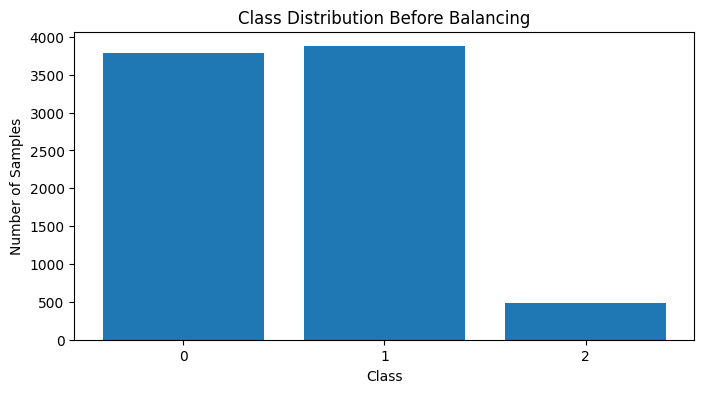

Class counts before balancing: [3791 3875  489]


In [16]:
import matplotlib.pyplot as plt

# Count the number of instances of each class before balancing
class_counts = torch.bincount(targets_combined)

# Plot the class distribution
plt.figure(figsize=(8, 4))
plt.bar(range(len(class_counts)), class_counts.numpy(), tick_label=list(range(len(class_counts))))
plt.title("Class Distribution Before Balancing")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

print("Class counts before balancing:", class_counts.numpy())

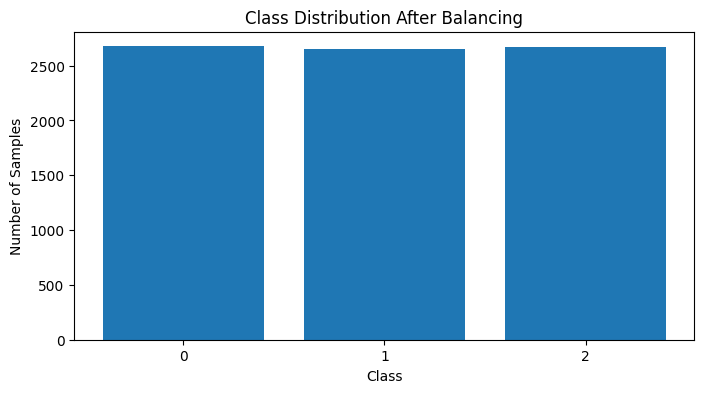

Class counts after balancing: [2676 2650 2674]


In [17]:
# Simulate sampling
num_samples_to_check = 8000  # You can increase this number for better accuracy
sampled_indices = list(sampler)[:num_samples_to_check]
sampled_targets = targets_combined[sampled_indices]

# Count the number of instances of each class after balancing
balanced_class_counts = torch.bincount(sampled_targets)

# Plot the class distribution after balancing
plt.figure(figsize=(8, 4))
plt.bar(range(len(balanced_class_counts)), balanced_class_counts.numpy(), tick_label=list(range(len(balanced_class_counts))))
plt.title("Class Distribution After Balancing")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

print("Class counts after balancing:", balanced_class_counts.numpy())

In [18]:
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets_combined['train'], batch_size = 32, sampler=sampler),
    'val': torch.utils.data.DataLoader(image_datasets_combined['val'], batch_size = 32),
    'test': torch.utils.data.DataLoader(image_datasets_combined['test'], batch_size = 32)
}

In [19]:
len(dataloaders['train'])

255

In [20]:
import torch.nn.functional as F
class BarlowTwinsLoss(nn.Module):
    def __init__(self, lambda_param: float = 5e-3, **kwargs):
        super(BarlowTwinsLoss, self).__init__()
        self.lambda_param = lambda_param

    def off_diagonal(self, x):
        # return a flattened view of the off-diagonal elements of a square matrix
        n, m = x.shape
        assert n == m
        return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

    def forward(self, z_a: torch.Tensor, z_b: torch.Tensor):
        # normalize repr. along the batch dimension
        z_a = F.normalize(z_a, dim=-1)
        z_b = F.normalize(z_b, dim=-1)
        # normalize the representations along the batch dimension
        out_1_norm = (z_a - z_a.mean(dim=0)) / z_a.std(dim=0)
        out_2_norm = (z_b - z_b.mean(dim=0)) / z_b.std(dim=0)

        # cross-correlation matrix
        batch_size = z_a.size(0)
        c = torch.matmul(out_1_norm.T, out_2_norm) / batch_size

        # loss
        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        off_diag = self.off_diagonal(c).add_(1).pow_(2).sum()
        loss = on_diag + self.lambda_param * off_diag

        return loss

In [21]:
class BarlowTwins(nn.Module):

    def __init__(
        self,
        backbone: nn.Module,
        feature_size: int,
        projection_dim: int = 8192,
        hidden_dim: int = 8192,
        **kwargs
    ):
        super().__init__()
        self.feature_size = feature_size
        self.projection_dim = projection_dim
        self.hidden_dim = hidden_dim
        self.backbone = backbone

        self.projection_head = nn.Sequential(
            nn.Sequential(nn.Linear(self.feature_size, self.hidden_dim), nn.BatchNorm1d(self.hidden_dim), nn.ReLU(inplace=True)),
            nn.Sequential(nn.Linear(self.hidden_dim, self.hidden_dim), nn.BatchNorm1d(self.hidden_dim), nn.ReLU(inplace=True)),
            nn.Sequential(nn.Linear(self.hidden_dim, self.projection_dim)))

        self.encoder = nn.Sequential(self.backbone, self.projection_head)

    def forward(self, x0: torch.Tensor, x1: torch.Tensor):
        f0 = self.backbone(x0).flatten(start_dim=1)
        out0 = self.projection_head(f0)

        f1 = self.backbone(x1).flatten(start_dim=1)
        out1 = self.projection_head(f1)

        return out0, out1

In [22]:
backbone = models.resnet50()
num_features = backbone.fc.in_features
backbone.fc = nn.Identity()

model = BarlowTwins(backbone=backbone, feature_size=num_features, projection_dim=128)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [23]:
print(f"Number of Model Parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Memmory Usage: {torch.cuda.memory_allocated(device) / 1024**3:.2f} GB")

Number of Model Parameters: 108491968
Memmory Usage: 0.40 GB


In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = BarlowTwinsLoss()
ssl_transform = SimCLRViewTransform()

### SSL training

In [25]:
import torch
import numpy as np
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load existing metrics if the file exists
metrics_file_path = "/content/drive/MyDrive/training_metrics_ssl_Barlow_training.pkl"

try:
    with open(metrics_file_path, 'rb') as f:
        metrics = pickle.load(f)
        print("Loaded existing metrics.")
except FileNotFoundError:
    metrics = {'train_loss': [], 'val_loss': []}
    print("No existing metrics found. Starting fresh.")

# Parameters for Early Stopping
early_stopping_patience = 5  # Stop after 5 epochs with no improvement
best_val_loss = float('inf')
patience_counter = 0

num_epochs = 100  # Set a higher number of epochs to allow early stopping

# model.load_state_dict(torch.load('/content/drive/MyDrive/model_ssl_epoch_100.pth'))

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            dataloader = dataloaders['train']
        else:
            model.eval()  # Set model to evaluate mode
            dataloader = dataloaders['val']

        running_loss = 0.0

        # Iterate over data with tqdm progress bar
        for inputs, _ in tqdm(dataloader, desc=f"{phase.capitalize()} Phase"):
            inputs = inputs.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            aug1 = ssl_transform(inputs)
            aug2 = ssl_transform(inputs)

            # Forward pass
            with torch.set_grad_enabled(phase == 'train'):
                out0, out1 = model(aug1, aug2)
                loss = criterion(out0, out1)

                # Backward pass + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)

        # Calculate metrics
        epoch_loss = running_loss / len(dataloader.dataset)

        # Save metrics
        metrics[f'{phase}_loss'].append(epoch_loss)

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}')

        # Early stopping check during validation phase
        if phase == 'val':
            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                patience_counter = 0  # Reset the counter if improvement occurs
                # Save the model weights when improvement occurs
                torch.save(model.state_dict(), '/content/drive/MyDrive/best_model_ssl_barlowTwins_training.pth')
            else:
                patience_counter += 1

        if (epoch+1) % 10 == 0:
            # Save the model weights every 10 epochs
            torch.save(model.state_dict(), f'/content/drive/MyDrive/model_ssl_Barlow_epoch_{epoch+1}.pth')
            # Save the metrics to the pickle file
            with open(metrics_file_path, 'wb') as f:
                pickle.dump(metrics, f)
            print(f"Metrics saved at epoch {epoch}.")

    print()

print(f"Final metrics saved to {metrics_file_path}")


Mounted at /content/drive
No existing metrics found. Starting fresh.
Epoch 1/100
----------


Train Phase: 100%|██████████| 255/255 [03:08<00:00,  1.36it/s]


Train Loss: 118.2816


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 183.4204

Epoch 2/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 106.0692


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.33it/s]


Val Loss: 220.6438

Epoch 3/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 102.9701


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 199.9862

Epoch 4/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.38it/s]


Train Loss: 102.4925


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 206.5966

Epoch 5/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 100.9424


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 230.8540

Epoch 6/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 99.6171


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 194.2436

Epoch 7/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 98.7330


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 185.4531

Epoch 8/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.36it/s]


Train Loss: 97.3514


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.34it/s]


Val Loss: 203.8778

Epoch 9/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 96.2323


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 193.7592

Epoch 10/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 95.7942
Metrics saved at epoch 9.


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 185.2651
Metrics saved at epoch 9.

Epoch 11/100
----------


Train Phase: 100%|██████████| 255/255 [03:07<00:00,  1.36it/s]


Train Loss: 95.4650


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 208.7368

Epoch 12/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 95.8642


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 174.8001

Epoch 13/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 95.3106


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 182.6791

Epoch 14/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 94.9950


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 182.9148

Epoch 15/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 94.3500


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 194.1100

Epoch 16/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 93.5271


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.33it/s]


Val Loss: 184.1497

Epoch 17/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 93.2235


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 175.9286

Epoch 18/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.38it/s]


Train Loss: 94.1172


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]


Val Loss: 169.6818

Epoch 19/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.38it/s]


Train Loss: 93.3629


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 167.6109

Epoch 20/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 93.1420
Metrics saved at epoch 19.


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.34it/s]


Val Loss: 176.4818
Metrics saved at epoch 19.

Epoch 21/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 92.0268


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 180.1022

Epoch 22/100
----------


Train Phase: 100%|██████████| 255/255 [03:04<00:00,  1.38it/s]


Train Loss: 92.4787


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 177.6725

Epoch 23/100
----------


Train Phase: 100%|██████████| 255/255 [03:07<00:00,  1.36it/s]


Train Loss: 91.3348


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 210.6931

Epoch 24/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 92.5778


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 204.2463

Epoch 25/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 92.2351


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 187.6380

Epoch 26/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.38it/s]


Train Loss: 93.3182


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.39it/s]


Val Loss: 174.0633

Epoch 27/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 93.0773


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]


Val Loss: 164.1891

Epoch 28/100
----------


Train Phase: 100%|██████████| 255/255 [03:04<00:00,  1.38it/s]


Train Loss: 92.1470


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 177.4721

Epoch 29/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 91.7215


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.32it/s]


Val Loss: 165.6238

Epoch 30/100
----------


Train Phase: 100%|██████████| 255/255 [03:07<00:00,  1.36it/s]


Train Loss: 91.8812
Metrics saved at epoch 29.


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 187.8499
Metrics saved at epoch 29.

Epoch 31/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 91.0861


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 179.9804

Epoch 32/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 90.5089


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]


Val Loss: 171.7689

Epoch 33/100
----------


Train Phase: 100%|██████████| 255/255 [03:04<00:00,  1.38it/s]


Train Loss: 91.6696


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 172.0094

Epoch 34/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.38it/s]


Train Loss: 90.7483


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 191.7546

Epoch 35/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 90.4902


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.39it/s]


Val Loss: 177.3137

Epoch 36/100
----------


Train Phase: 100%|██████████| 255/255 [03:04<00:00,  1.38it/s]


Train Loss: 90.5862


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 166.5848

Epoch 37/100
----------


Train Phase: 100%|██████████| 255/255 [03:04<00:00,  1.38it/s]


Train Loss: 89.8321


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]


Val Loss: 192.9096

Epoch 38/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.38it/s]


Train Loss: 89.7836


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 187.8082

Epoch 39/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 90.3199


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.34it/s]


Val Loss: 208.9740

Epoch 40/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.38it/s]


Train Loss: 90.5781
Metrics saved at epoch 39.


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 187.7920
Metrics saved at epoch 39.

Epoch 41/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 90.6529


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 208.6850

Epoch 42/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 90.2065


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 179.8731

Epoch 43/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 89.2383


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 180.9633

Epoch 44/100
----------


Train Phase: 100%|██████████| 255/255 [03:07<00:00,  1.36it/s]


Train Loss: 89.4512


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.39it/s]


Val Loss: 179.2938

Epoch 45/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.36it/s]


Train Loss: 89.1191


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.34it/s]


Val Loss: 198.9362

Epoch 46/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.38it/s]


Train Loss: 90.0511


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 204.3822

Epoch 47/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 89.4196


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.34it/s]


Val Loss: 186.7086

Epoch 48/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 89.3220


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 182.4969

Epoch 49/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 89.3182


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 201.2442

Epoch 50/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 88.9678
Metrics saved at epoch 49.


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 184.6310
Metrics saved at epoch 49.

Epoch 51/100
----------


Train Phase: 100%|██████████| 255/255 [03:07<00:00,  1.36it/s]


Train Loss: 89.2681


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 173.5760

Epoch 52/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 88.5701


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 185.8567

Epoch 53/100
----------


Train Phase: 100%|██████████| 255/255 [03:04<00:00,  1.38it/s]


Train Loss: 89.6853


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 188.7091

Epoch 54/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.38it/s]


Train Loss: 90.2469


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 162.6740

Epoch 55/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 88.7005


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 189.6424

Epoch 56/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 88.6348


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.34it/s]


Val Loss: 182.9766

Epoch 57/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 88.8563


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 159.0369

Epoch 58/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.38it/s]


Train Loss: 89.0676


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]


Val Loss: 186.1763

Epoch 59/100
----------


Train Phase: 100%|██████████| 255/255 [03:07<00:00,  1.36it/s]


Train Loss: 88.5647


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 175.9977

Epoch 60/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.38it/s]


Train Loss: 88.7710
Metrics saved at epoch 59.


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 196.8513
Metrics saved at epoch 59.

Epoch 61/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 88.6507


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 204.2889

Epoch 62/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.38it/s]


Train Loss: 88.1135


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.34it/s]


Val Loss: 203.4371

Epoch 63/100
----------


Train Phase: 100%|██████████| 255/255 [03:04<00:00,  1.38it/s]


Train Loss: 88.6069


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.34it/s]


Val Loss: 183.7011

Epoch 64/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 88.0850


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 174.1283

Epoch 65/100
----------


Train Phase: 100%|██████████| 255/255 [03:07<00:00,  1.36it/s]


Train Loss: 88.0114


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 181.3838

Epoch 66/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 88.1606


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 211.8247

Epoch 67/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 87.9359


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 194.5814

Epoch 68/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.38it/s]


Train Loss: 87.8706


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 194.7564

Epoch 69/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 88.1355


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 175.9235

Epoch 70/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.38it/s]


Train Loss: 87.2478
Metrics saved at epoch 69.


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 204.4759
Metrics saved at epoch 69.

Epoch 71/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 88.2478


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 194.3774

Epoch 72/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 87.5731


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 204.6928

Epoch 73/100
----------


Train Phase: 100%|██████████| 255/255 [03:04<00:00,  1.38it/s]


Train Loss: 87.9156


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]


Val Loss: 166.7000

Epoch 74/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 88.9873


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 197.6371

Epoch 75/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 87.7850


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 198.1664

Epoch 76/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 88.4485


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 185.1577

Epoch 77/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 87.5384


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.34it/s]


Val Loss: 187.6088

Epoch 78/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 88.2716


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 163.5217

Epoch 79/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 87.3259


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.34it/s]


Val Loss: 189.3777

Epoch 80/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 87.0601
Metrics saved at epoch 79.


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 202.3583
Metrics saved at epoch 79.

Epoch 81/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 87.1677


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 172.5069

Epoch 82/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 87.6007


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 201.8560

Epoch 83/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.38it/s]


Train Loss: 87.1876


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 184.4297

Epoch 84/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 87.1632


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 176.4521

Epoch 85/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 87.1635


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 202.8928

Epoch 86/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 87.2496


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 186.3264

Epoch 87/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 87.2261


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.34it/s]


Val Loss: 203.5262

Epoch 88/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 87.9384


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 183.4396

Epoch 89/100
----------


Train Phase: 100%|██████████| 255/255 [03:04<00:00,  1.38it/s]


Train Loss: 87.5440


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 200.2756

Epoch 90/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.36it/s]


Train Loss: 87.3928
Metrics saved at epoch 89.


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 165.8410
Metrics saved at epoch 89.

Epoch 91/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 87.2832


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 179.7134

Epoch 92/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.38it/s]


Train Loss: 87.1853


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 177.0148

Epoch 93/100
----------


Train Phase: 100%|██████████| 255/255 [03:04<00:00,  1.38it/s]


Train Loss: 88.1561


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 171.4946

Epoch 94/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 87.1381


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]


Val Loss: 194.9265

Epoch 95/100
----------


Train Phase: 100%|██████████| 255/255 [03:04<00:00,  1.38it/s]


Train Loss: 87.1509


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 184.4903

Epoch 96/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 86.8294


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 184.1926

Epoch 97/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.38it/s]


Train Loss: 87.4935


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 189.5114

Epoch 98/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 87.7850


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Val Loss: 195.0425

Epoch 99/100
----------


Train Phase: 100%|██████████| 255/255 [03:06<00:00,  1.37it/s]


Train Loss: 87.8653


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Val Loss: 177.6479

Epoch 100/100
----------


Train Phase: 100%|██████████| 255/255 [03:05<00:00,  1.37it/s]


Train Loss: 87.1079
Metrics saved at epoch 99.


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 185.6886
Metrics saved at epoch 99.

Final metrics saved to /content/drive/MyDrive/training_metrics_ssl_Barlow_training.pkl


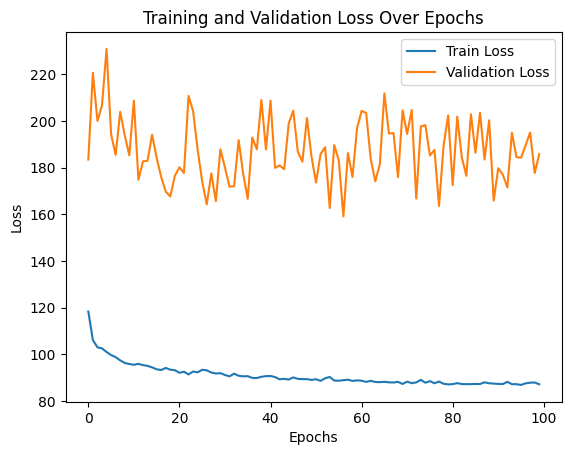

In [26]:
import pickle
import matplotlib.pyplot as plt

metrics_file_path = "/content/drive/MyDrive/training_metrics_ssl_Barlow_training.pkl"

with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)

# Plotting the metrics
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

# Freeze the backbone
for param in model.backbone.parameters():
    param.requires_grad = True

# Replace the backbone's classifier with a new linear layer
num_classes = 3  # Number of classes in your dataset
num_features = model.backbone.fc.in_features  # Get the number of input features for the classifier
model.backbone.fc = nn.Linear(num_features, num_classes)
model = model.backbone.to(device)

# Define loss function and optimizer for the linear classifier
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Metrics storage
train_losses = []
train_accuracies = []

num_epochs_linear = 100  # Adjust as needed

for epoch in range(num_epochs_linear):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(dataloaders['train'], desc=f"Linear Eval Epoch {epoch+1}"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloaders['train'].dataset)
    epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    print(f"Linear Eval Epoch {epoch+1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")


AttributeError: 'Identity' object has no attribute 'in_features'

NameError: name 'num_epochs_linear' is not defined

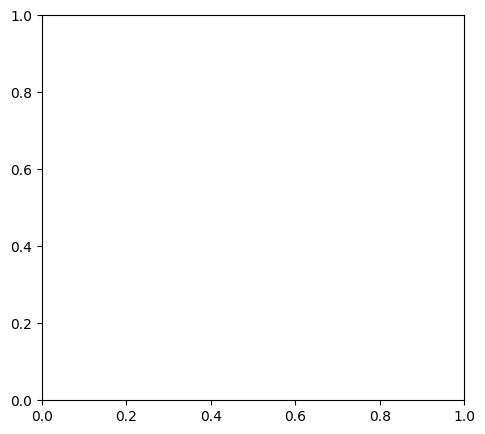

In [28]:

# Plotting the training loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs_linear + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs_linear + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Validation on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate evaluation metrics
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Test Set - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
